# Prediction of hardness based on chemical formula and load (state)

This notebooks applies MODNet on [a hardness dataset extracted from literature](https://github.com/ziyan1996/VickersHardnessPrediction). It is a good example on how MODNet can be used for a composition-only task
with state variables such as temperature or pressure or in this case the applied load
(N) during hardness testing.

The citation for hardness data used is as follows:
> Zhang. Z, Tehrani. A.M., Oliynyk. A.O., Day. B and Brgoch. J, Finding Superhard Materials through Ensemble Learning, Adv. Mater. 2020, 33, 2005112.

## Dependencies

In [6]:
# !pip3 install ml-matrics

In [1]:
from os.path import join
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from modnet.models import MODNetModel
from modnet.preprocessing import MODData
import matplotlib.pyplot as plt 
# from ml_matrics.parity import density_scatter, density_hexbin
from pymatgen.core import Composition

2023-08-27 17:13:19.386212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 17:13:20.257027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-27 17:13:20.257115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-27 17:13:20.257126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [8]:
df = pd.read_csv(join("data","hv_comp_load","hv_comp_load.csv"))

In [9]:
df

,composition,hardness,load
0,Ag0.05Gd0.048Pd0.902,1.810,0.49
1,Ag0.05Y0.048Pd0.902,1.640,0.49
2,Ag0.25Pb0.5Sb0.25Te,0.578,2.94
3,Al1.5Si1.5N2.5O1.5,15.030,0.98
4,Al1.67B22,23.800,2.00
...,...,...,...
1057,ZrV2,3.600,0.98
1058,ZrW2,11.100,0.98
1059,OsB2,34.800,0.25
1060,OsB2,27.000,0.49


The Zhang et al. hardness dataset contains 1062 individual Vickers hardness measurements
at various loads.

In [2]:
df = pd.read_csv(join("data","hv_comp_load","hv_comp_load.csv"))
# df = df.iloc[0:100] # uncomment if you only want to use a small subset of the data
df["composition"] = df["composition"].map(Composition) # maps composition to a pymatgen composition object
target_name = "hardness"
state_name = "load"
df.head()

,composition,hardness,load
0,"(Ag, Gd, Pd)",1.810,0.49
1,"(Ag, Y, Pd)",1.640,0.49
2,"(Ag, Pb, Sb, Te)",0.578,2.94
3,"(Al, Si, N, O)",15.030,0.98
4,"(Al, B)",23.800,2.00


In [3]:
df.describe()

,hardness,load
count,1062.000000,1062.000000
mean,25.011255,2.334731
std,13.567154,3.613743
min,0.250000,0.001500
25%,11.305000,0.590000
50%,28.448737,0.980000
75%,34.266283,2.940000
max,92.000000,49.030000


We can view the distribution of the data (load and hardness values) via a hexagonally
binned scatter plot, or "hexbin".

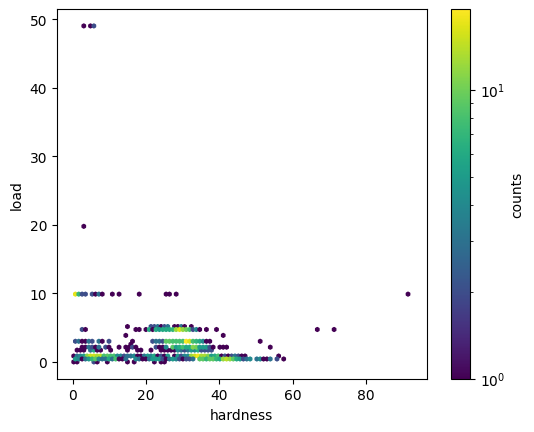

In [4]:
fig, ax = plt.subplots(facecolor="w")
hb = ax.hexbin(df[target_name], df[state_name], bins="log")
plt.ylabel(state_name)
plt.xlabel(target_name)
ax.set_box_aspect(1)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

Or via a more traditional x-y scatter plot:

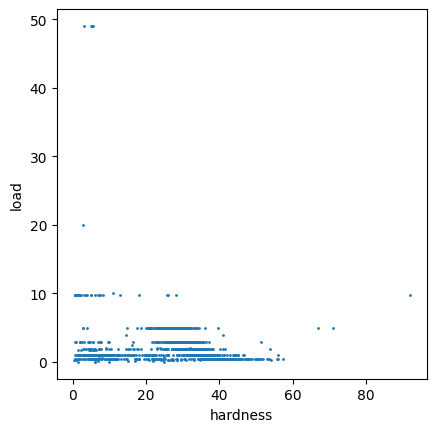

In [5]:
fig, ax = plt.subplots(facecolor="w")
ax.scatter(df[target_name], df[state_name],s=1)
plt.ylabel(state_name)
plt.xlabel(target_name)
ax.set_box_aspect(1)

## MODData

In [6]:
# This instantiates the MODData
data = MODData(
    materials=df["composition"], # you can provide composition objects to MODData
    targets=df[target_name], 
    target_names=[target_name]
)

2023-08-27 17:13:53,629 - modnet - INFO - Loaded CompositionOnlyMatminer2023Featurizer featurizer.


In [13]:
# Featurization of the moddata
# It will automatically apply composition only featurizers
data.featurize()

2023-08-26 00:12:24,973 - modnet - INFO - Computing features, this can take time...
2023-08-26 00:12:24,975 - modnet - INFO - Applying composition featurizers...
2023-08-26 00:12:24,980 - modnet - INFO - Applying featurizers (AtomicOrbitals(), AtomicPackingEfficiency(), BandCenter(), ElementFraction(), ElementProperty(data_source=<matminer.utils.data.MagpieData object at 0x7f813f7b97c0>,
                features=['Number', 'MendeleevNumber', 'AtomicWeight',
                          'MeltingT', 'Column', 'Row', 'CovalentRadius',
                          'Electronegativity', 'NsValence', 'NpValence',
                          'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
                          'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled',
                          'GSvolume_pa', 'GSbandgap', 'GSmagmom',
                          'SpaceGroupNumber'],
                stats=['minimum', 'maximum', 'range', 'mean', 'avg_dev',
                       'mode']), IonProperty(),

MultipleFeaturizer:  44%|████▍     | 472/1062 [00:01<00:01, 354.77it/s]/scratch/yll6162/miniconda/envs/modnet/lib/python3.9/site-packages/matminer/featurizers/composition/alloy.py:198: RuntimeWarning: invalid value encountered in power
  alp_a = np.multiply(1.5, np.power(v_a, 2 / 3)) / reduce(lambda x, y: 1 / x + 1 / y, np.power(n_ws, 1 / 3))
/scratch/yll6162/miniconda/envs/modnet/lib/python3.9/site-packages/matminer/featurizers/composition/alloy.py:198: RuntimeWarning: invalid value encountered in power
  alp_a = np.multiply(1.5, np.power(v_a, 2 / 3)) / reduce(lambda x, y: 1 / x + 1 / y, np.power(n_ws, 1 / 3))
MultipleFeaturizer:  81%|████████▏ | 863/1062 [00:07<00:02, 68.27it/s]/scratch/yll6162/miniconda/envs/modnet/lib/python3.9/site-packages/matminer/featurizers/composition/alloy.py:198: RuntimeWarning: invalid value encountered in power
  alp_a = np.multiply(1.5, np.power(v_a, 2 / 3)) / reduce(lambda x, y: 1 / x + 1 / y, np.power(n_ws, 1 / 3))
/scratch/yll6162/miniconda/envs/modne

2023-08-26 00:12:45,354 - modnet - INFO - Data has successfully been featurized!


### add hardness data post-hoc

In [14]:
data.df_featurized[state_name] = df[state_name].values

In [15]:
data.df_featurized

,AtomicOrbitals|HOMO_character,AtomicOrbitals|HOMO_element,AtomicOrbitals|HOMO_energy,AtomicOrbitals|LUMO_character,AtomicOrbitals|LUMO_element,AtomicOrbitals|LUMO_energy,AtomicOrbitals|gap_AO,AtomicPackingEfficiency|mean simul. packing efficiency,AtomicPackingEfficiency|mean abs simul. packing efficiency,AtomicPackingEfficiency|dist from 1 clusters |APE| < 0.010,...,ValenceOrbital|avg p valence electrons,ValenceOrbital|avg d valence electrons,ValenceOrbital|avg f valence electrons,ValenceOrbital|frac s valence electrons,ValenceOrbital|frac p valence electrons,ValenceOrbital|frac d valence electrons,ValenceOrbital|frac f valence electrons,YangSolidSolution|Yang omega,YangSolidSolution|Yang delta,load
id,,,,,,,,,,,,,,,,,,,,,
id0,3,46,-0.160771,3,46,-0.160771,0.000000,0.011270,0.013120,0.016120,...,0.000000,9.568000,0.336000,0.014527,0.000000,0.952040,0.033433,3.587849e-01,0.050501,0.49
id1,1,39,-0.150727,1,39,-0.150727,0.000000,0.011100,0.011407,0.016120,...,0.000000,9.568000,0.000000,0.015030,0.000000,0.984970,0.000000,3.608379e-01,0.054901,0.49
id2,2,52,-0.226594,2,51,-0.185623,0.040971,0.002165,0.025647,0.061237,...,2.875000,10.000000,3.500000,0.102740,0.157534,0.547945,0.191781,7.854369e+06,0.093935,2.94
id3,2,7,-0.266297,2,7,-0.266297,0.000000,-0.017054,0.023132,0.010758,...,2.571429,0.000000,0.000000,0.437500,0.562500,0.000000,0.000000,6.726751e+06,0.320641,0.98
id4,2,5,-0.136603,2,5,-0.136603,0.000000,-0.016771,0.016771,0.023197,...,1.000000,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,4.767616e+06,0.147942,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id1057,3,23,-0.204634,3,23,-0.204634,0.000000,-0.023942,0.023942,0.029463,...,0.000000,2.666667,0.000000,0.428571,0.000000,0.571429,0.000000,3.221823e+00,0.079674,0.98
id1058,3,74,-0.220603,3,74,-0.220603,0.000000,-0.023617,0.023617,0.029463,...,0.000000,3.333333,9.333333,0.136364,0.000000,0.227273,0.636364,2.098711e+00,0.075997,0.98
id1059,3,76,-0.296791,1,76,-0.191489,0.105302,-0.029887,0.029887,0.049622,...,0.666667,2.000000,4.666667,0.214286,0.071429,0.214286,0.500000,6.616627e-01,0.213724,0.25


### train-test split

In [16]:
from sklearn.model_selection import train_test_split
split = train_test_split(range(df.shape[0]), test_size=0.1, random_state=1234)
train, test = data.split(split)

In [17]:
train.feature_selection(n=-1)

2023-08-26 00:13:28,410 - modnet - INFO - Multiprocessing on 1 workers.
2023-08-26 00:13:28,413 - modnet - INFO - Computing "self" MI (i.e. information entropy) of features


100%|██████████| 271/271 [00:04<00:00, 66.09it/s]

2023-08-26 00:13:32,577 - modnet - INFO - Computing cross NMI between all features...



100%|██████████| 15225/15225 [03:17<00:00, 77.04it/s]

2023-08-26 00:16:50,519 - modnet - INFO - Starting target 1/1: hardness ...
2023-08-26 00:16:50,521 - modnet - INFO - Computing mutual information between features and target...



/scratch/yll6162/miniconda/envs/modnet/lib/python3.9/site-packages/modnet/preprocessing.py:151: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  mutual_info.loc[:, target_name] = _mifun(df_feat, df_target[target_name], **kwargs)


2023-08-26 00:16:56,889 - modnet - INFO - Computing optimal features...
2023-08-26 00:17:02,074 - modnet - INFO - Selected 50/170 features...
2023-08-26 00:17:06,281 - modnet - INFO - Selected 100/170 features...
2023-08-26 00:17:08,792 - modnet - INFO - Selected 150/170 features...
2023-08-26 00:17:09,038 - modnet - INFO - Done with target 1/1: hardness.
2023-08-26 00:17:09,039 - modnet - INFO - Merging all features...
2023-08-26 00:17:09,041 - modnet - INFO - Done.


In [18]:
state_name in train.optimal_features

True

## MODNet model

In [19]:
model = MODNetModel([[[target_name]]],
                    weights={target_name:1},
                    num_neurons = [[256], [128], [16], [16]],
                    n_feat = 150,
                    act =  "elu"
                   )

2023-08-26 00:17:09.789225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 00:17:10.424691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12043 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-08-26 00:17:10.427156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14791 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


### training

In [20]:
model.fit(train,
          val_fraction = 0.1,
          lr = 0.0002,
          batch_size = 64,
          loss = 'mae',
          epochs = 100,
          verbose = 1,
         )

epoch 0: loss: 22.295, val_loss:20.700 val_mae:20.700
epoch 1: loss: 19.108, val_loss:17.658 val_mae:17.658
epoch 2: loss: 16.068, val_loss:14.705 val_mae:14.705
epoch 3: loss: 12.984, val_loss:11.533 val_mae:11.533
epoch 4: loss: 9.698, val_loss:8.271 val_mae:8.271
epoch 5: loss: 7.364, val_loss:7.558 val_mae:7.558
epoch 6: loss: 6.910, val_loss:6.869 val_mae:6.869
epoch 7: loss: 6.330, val_loss:6.177 val_mae:6.177
epoch 8: loss: 5.919, val_loss:5.927 val_mae:5.927
epoch 9: loss: 5.698, val_loss:5.814 val_mae:5.814
epoch 10: loss: 5.544, val_loss:5.707 val_mae:5.707
epoch 11: loss: 5.426, val_loss:5.609 val_mae:5.609
epoch 12: loss: 5.298, val_loss:5.530 val_mae:5.530
epoch 13: loss: 5.205, val_loss:5.424 val_mae:5.424
epoch 14: loss: 5.123, val_loss:5.314 val_mae:5.314
epoch 15: loss: 5.054, val_loss:5.223 val_mae:5.223
epoch 16: loss: 4.994, val_loss:5.132 val_mae:5.132
epoch 17: loss: 4.933, val_loss:5.161 val_mae:5.161
epoch 18: loss: 4.902, val_loss:5.025 val_mae:5.025
epoch 19: 

### Predicting

In [22]:
pred = model.predict(test)
pred.head()

4/4 [==============================] - 0s 16ms/step


,hardness
id207,7.131758
id661,33.168446
id1049,8.694278
id470,34.421829
id485,6.085532


### Model Performance

#### Mean Absolute Error

In [23]:
mae_test = np.absolute(pred.values-test.df_targets.values).mean()
print(f'mae: {mae_test}')

mae: 4.62163162184845


#### Hexagonally-binned parity plot

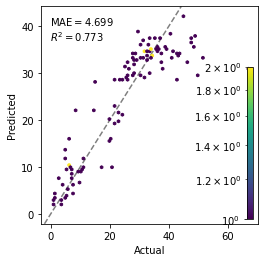

In [76]:
# ax = density_hexbin(test.df_targets.values, pred.values)
# ax.set_box_aspect(1)

#### Traditional parity plot

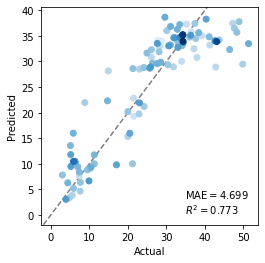

In [77]:
ax = density_scatter(test.df_targets.values.ravel(), pred.values.ravel())
ax.set_box_aspect(1)